**Summary:**

Training initial VGG16 model on 2-type classification problem.

In [0]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import torchvision.models as models

# Load & preprocess data

Load data labels and convert to 2-type classification problem (healthy, injured)

In [0]:
labels = pd.read_csv('drive/My Drive/ICH/train_labels.csv')

def healthy_label(rows):
    if rows.sum() == 0: return 1;
    else: return 0

labels['healthy'] = labels[['epidural', 'intraparenchymal', 'subarachnoid']].apply(lambda row: healthy_label(row), axis=1)

In [8]:
healthy = labels[labels['healthy'] == 1]
injured = labels[labels['healthy'] == 0]
print('healthy: ', len(healthy.index), 'injured: ', len(injured.index))

healthy:  3463 injured:  5079


In [9]:
labels_2type = labels[['ID', 'healthy']]
labels_2type['ID'] = labels_2type['ID'].apply(lambda x: x + '.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Images loaded to GPU workstation in train_images file.

Image transformations applied in accordance with procedure detailed in supplementary materials of 'Precise diagnosis of intracranial hemorrhage and subtypes using a three-dimensional joint convolutionaland recurrent neural network' - Yu et al:

**"In the training process, we applied online augmentation to the training images to reduce overfitting, including rotation (0-180 degrees), scaling (90%-110%), shifting (10%), sheering (10%), as well as horizontal and vertical ﬂipping."**

Images are also upscaled to 256x256 as performed in Yu et al.


In [0]:
path = 'train_images/'
p = 0.5
tfms = [[rotate(degrees=(-180, 180),  p=p), crop_pad(p=p), dihedral(p=p, use_on_y=True), zoom(scale=(0.9,1.1), p=p), pad(p=p)],[]]
data = ImageDataBunch.from_df(path, labels_2type, bs=24, ds_tfms=tfms, size=(256, 256))

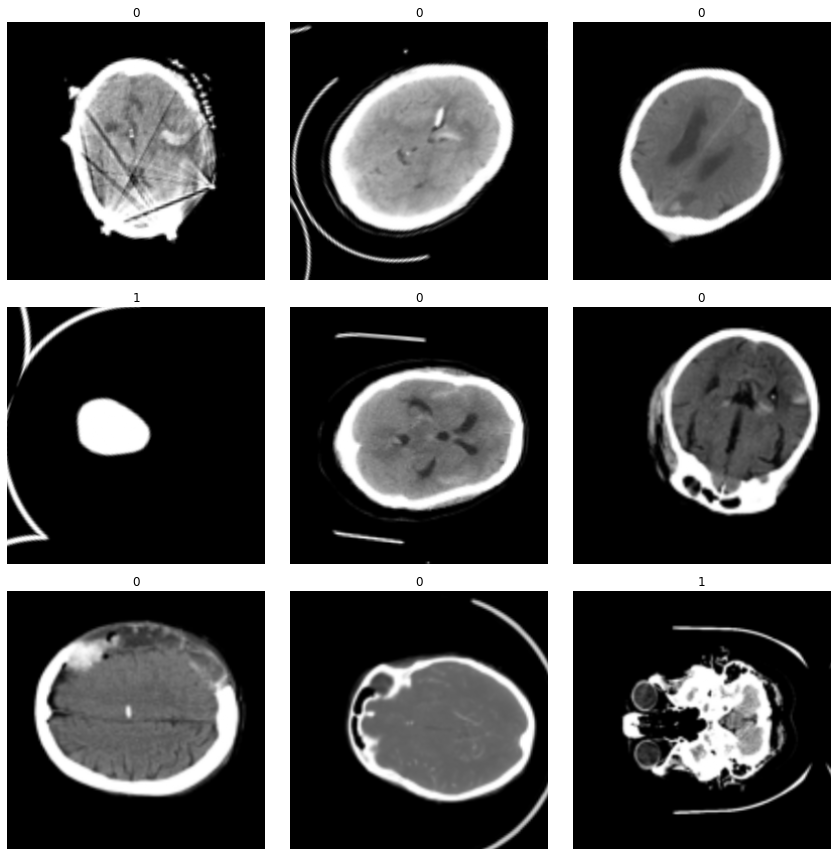

In [11]:
data.show_batch(3)

In [12]:
data.train_ds, data.valid_ds

(LabelList (6834 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 0,0,0,0,0
 Path: train_images, LabelList (1708 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 0,1,1,1,0
 Path: train_images)

In [13]:
vgg16 = models.vgg16(pretrained=True)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Load VGG16 and dataset into fast ai api learner object for training

In [0]:
learn = Learner(data, vgg16, metrics=[error_rate, AUROC()])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


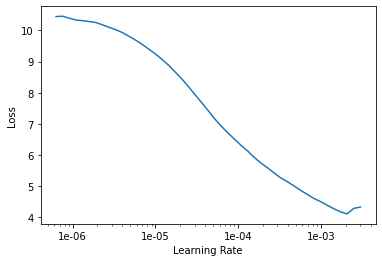

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.470174,0.360593,0.160422,0.879176,05:13
1,0.358673,0.325386,0.134075,0.652784,05:12
2,0.318891,0.310961,0.130562,0.617024,05:13
3,0.262734,0.257789,0.113583,0.795040,05:12
4,0.211413,0.245015,0.104801,0.727118,05:13


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [0]:
learn.save('vgg-first')

In [0]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.212492,0.245225,0.104215,0.729696,05:13
1,0.202050,0.244728,0.103044,0.723852,05:13
2,0.204123,0.244352,0.104215,0.729685,05:13


In [0]:
learn.save('vgg-second')
learn.save('../../drive/My Drive/ICH/models/vgg-2-type-second')

# Output Embeddings:

Generate intermediate embedding vectors from training images for further classification using GRU rnn network.

In [0]:
!mkdir train_images/models

In [17]:
learn.load('../../drive/My Drive/ICH/vgg-2-type-second')

Learner(data=ImageDataBunch;

Train: LabelList (6834 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: train_images;

Valid: LabelList (1708 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,1,1,1,0
Path: train_images;

Test: None, model=VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2,

In [0]:
#save output of classifier layer
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

sf = SaveFeatures(list(learn.model.children())[2][3])

Test on single image

In [0]:
im = open_image('train_images/train_512.png')
learn.predict(im)
embedding = sf.features[0]
print(len(embedding))

4096


Calculate intermediate embedding for each of train images and save for use by rnn model

In [0]:
import os 
img_files_train = os.listdir('train_images')
img_files_train.remove('models')

def build_embeddings(folder, file_list):
  file_names = []
  embeddings = []
  for f in file_list:
    learn.predict(open_image(folder + f))
    emb = sf.features[0]
    file_names.append(f)
    embeddings.append(emb)
  return embeddings, file_names

# embeddings_train, file_names_train = build_embeddings('train_images/', img_files_train)

# np.save('drive/My Drive/ICH/Data/embeddings', embeddings_train)
# np.save('drive/My Drive/ICH/Data/embedding_references', file_names_train)

# Test images inference

Perform predictions on test images and save intermediate embeddings ready for rnn inference

In [0]:
img_files_test = os.listdir('test_images')

embeddings_test, file_names_test = build_embeddings('test_images/', img_files_test)

In [0]:
# np.save('drive/My Drive/ICH/Inference/CNN_2type_emb', embeddings_test)
np.save('drive/My Drive/ICH/Inference/CNN_2type_emb_refs', file_names_test)
